# Typos de RNNs en Keras

https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

![alt text](rnn_types.jpeg "Title")

In [60]:
from numpy import array
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, LSTM, SimpleRNN, Input, Masking, TimeDistributed
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG, display
from pprint import pprint

In [61]:
def graph_model(model):
    converter = model_to_dot(model, show_shapes=True, show_layer_names=True)
    image = converter.create(prog='dot', format='svg')
    display(SVG(image))

def show_model(model):
    print(model.summary())
    show_input_shape(model)
    graph_model(model)

def show_value(name, value): 
    print(f'\n{name}:')
    print(f'  - Shape: {value.shape}')
    print(f'  - Samples: {value.shape[0]}')
    str = np.array2string(value).replace('\n','\n\t   ')
    print(f'  - Value: {str}')

def show_input_shape(model):
    print('\nLayers input shape:')
    for layer in model.layers: print(f'- {layer.name}: {layer.input_shape}')
    print()

def show_output(X, y, prediction):
    show_value('X', X)
    show_value('y', y)
    show_value('Prediction', prediction)

## One-to-One
- No se usa el tiempo.
- Es equivalente a usar MLP.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_18 (SimpleRNN)    (None, 2)                 8         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 3         
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
None

Layers input shape:
- simple_rnn_18: (None, 1, 1)
- dense_32: (None, 2)



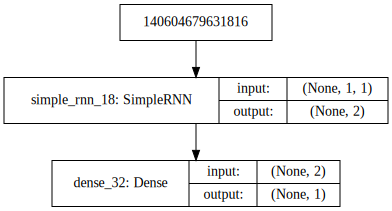

In [62]:
# prepare sequence
length = 5

seq = array([i/float(length) for i in range(length)])

X = seq.reshape(len(seq), 1, 1)
y = seq.reshape(len(seq), 1)

n_neurons = 2

# create LSTM
model = Sequential()
model.add(SimpleRNN(n_neurons, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

show_model(model)

### Calculo de nº de parametros en una capa oculta de la RNN

* M = Nº de neuronas.
* N = Nº de features.

**Nº Parametros = M^2 + M + (N*M)**


=> Si M=2 y N=1 => Cantitdad de parametros = 2^2 + 2 + 1*2 = 4 + 2 + 2 = 8

### Calculo de nº de parametros en una capa Densa

* A = Nº de entradas a la capa densa.
* B = Nº de neuronas de la capa densa.

**Nº Parametros = B*A + B** (Se suma B por que hay un bias por cada neurona).

=> Si A=2 y B=1 => Cantitdad de parametros = 1*2 + 1 = 3

In [63]:
# train LSTM

n_batch = length
n_epoch = 2000

model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=0)

In [64]:
result = model.predict(X, batch_size=n_batch, verbose=0)

show_output(X, y, result)


X:
  - Shape: (5, 1, 1)
  - Samples: 5
  - Value: [[[0. ]]
	   
	    [[0.2]]
	   
	    [[0.4]]
	   
	    [[0.6]]
	   
	    [[0.8]]]

y:
  - Shape: (5, 1)
  - Samples: 5
  - Value: [[0. ]
	    [0.2]
	    [0.4]
	    [0.6]
	    [0.8]]

Prediction:
  - Shape: (5, 1)
  - Samples: 5
  - Value: [[-0.01447999]
	    [ 0.2056413 ]
	    [ 0.41680524]
	    [ 0.6102489 ]
	    [ 0.78012145]]


**Nota**
* Son 5 muestras.
* No es una secuencia ya que T=1.
* Cada muestra de 1 feature.

## Many-to-one

- Otro ejemplo sería el de generación de texto como el de "Bodas de Sangre"
- Sentiment analisys
- Detección de SPAM
- Interesante utilizar Global Max pooling en vez de return_sequences en false. Para secuencias largas esto puede ser mas eficiente debido a la naturaleza de las RNN de quizas olvidar el largo plazo. (Ejemplo: Mail largo en detección de SPAM donde al principio hay algo que determina muy claramente que es SPAM)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_19 (SimpleRNN)    (None, 2)                 8         
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 15        
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________
None

Layers input shape:
- simple_rnn_19: (None, 5, 1)
- dense_33: (None, 2)



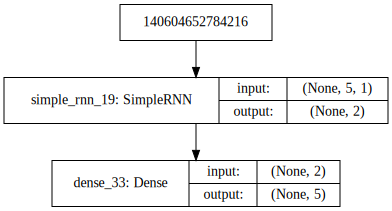

In [65]:
# Prepare sequence
length = 5

seq = array([i/float(length) for i in range(length)])

X = seq.reshape(1, length, 1)
y = seq.reshape(1, length)

n_neurons = 2

# Create LSTM
model = Sequential()
model.add(SimpleRNN(n_neurons, input_shape=(length, 1)))
model.add(Dense(length))
model.compile(loss='mean_squared_error', optimizer='adam')

show_model(model)

In [66]:
# train LSTM
n_batch = 1
n_epoch = 1000

model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=0)

In [67]:
result = model.predict(X, batch_size=n_batch, verbose=0)

show_output(X, y, result)


X:
  - Shape: (1, 5, 1)
  - Samples: 1
  - Value: [[[0. ]
	     [0.2]
	     [0.4]
	     [0.6]
	     [0.8]]]

y:
  - Shape: (1, 5)
  - Samples: 1
  - Value: [[0.  0.2 0.4 0.6 0.8]]

Prediction:
  - Shape: (1, 5)
  - Samples: 1
  - Value: [[-3.2782555e-07  1.9999032e-01  3.9990950e-01  6.0004365e-01
	      8.0000210e-01]]


**Nota**
* En la entrada una sola muestra con una secuencia de T=5 y 1 feature.
* A la salida de la RNN, solo toma las 2 neuronas de la **ultima etapa temporal** y las combina hacia una capa densa de 5 neuronas. 

**Nº parametros de capa densa** = 2x5 + 5(bias de cada neurona de la densa) = 15

## Many-to-Many
- POS es un buen ejemplo
- Igual que tramas de video

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_20 (SimpleRNN)    (None, 5, 2)              8         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 5, 1)              3         
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
None

Layers input shape:
- simple_rnn_20: (None, 5, 1)
- time_distributed_5: (None, 5, 2)



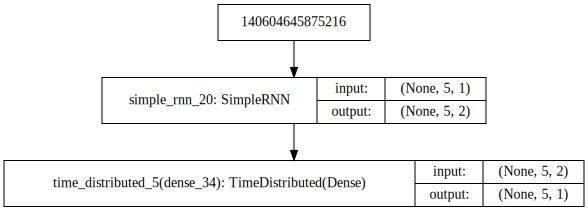

In [68]:
# Prepare sequence
length = 5

seq = array([i/float(length) for i in range(length)])

X = seq.reshape(1, length, 1)
y = seq.reshape(1, length, 1)

# Define LSTM configuration
n_neurons = 2

# Create LSTM
model = Sequential()
model.add(SimpleRNN(n_neurons, input_shape=(length, 1), return_sequences=True))

# Probar de cambiar Dense(2), etc
model.add(TimeDistributed(Dense(1)))

# model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

show_model(model)

In [69]:
# Train LSTM
n_batch = 1
n_epoch = 2000

model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=0)

In [70]:
result = model.predict(X, batch_size=n_batch, verbose=0)

show_output(X, y, result)


X:
  - Shape: (1, 5, 1)
  - Samples: 1
  - Value: [[[0. ]
	     [0.2]
	     [0.4]
	     [0.6]
	     [0.8]]]

y:
  - Shape: (1, 5, 1)
  - Samples: 1
  - Value: [[[0. ]
	     [0.2]
	     [0.4]
	     [0.6]
	     [0.8]]]

Prediction:
  - Shape: (1, 5, 1)
  - Samples: 1
  - Value: [[[0.00383428]
	     [0.19948396]
	     [0.3903849 ]
	     [0.61046374]
	     [0.7966172 ]]]


**Nota**
* La salida toma las 5 salidas temporales.
* Una neurona por cada T: Cada salida de la RNN va hacia una densa de una neurona.
* Los pesos se comparten.
    * Si lo pensamos bien hay solo 3 parametros en la capa densa.
    * Por que? Bueno si tenemos en cuenta que en una RNN los pessos de cada salida temporal hacia la densa se comparten (entre todas la salidas temporales), el número de parametros de la densa no cambia para N salidas temporales, siempre va a ser 3. 

## One-to-Many

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 1)                 2         
_________________________________________________________________
repeat_vector_23 (RepeatVect (None, 10, 1)             0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 10, 1)             12        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None

Layers input shape:
- dense_43: (None, 1)
- repeat_vector_23: (None, 1)
- lstm_22: (None, 10, 1)



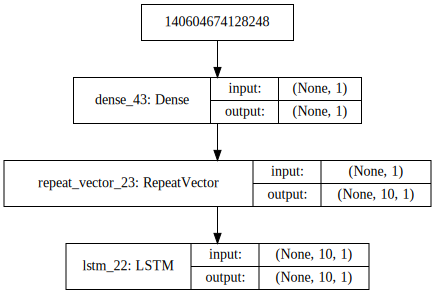

In [79]:
model = Sequential()

model.add(Dense(1, input_shape=(1,)))

# Repite el vector temporalmente.
model.add(RepeatVector(10))

# Define LSTM configuration
n_neurons = 1

model.add(LSTM(n_neurons, return_sequences=True))
# model.add(SimpleRNN(n_neurons, return_sequences=True))

show_model(model)

### Calculo de nº de parametros en una capa Densa

=> Si A=1 y B=1 => Nº de parametros = 1*1 + 1 = 2

### Calculo de nº de parametros en una capa oculta de la RNN

=> Si M=1 y N=1 => Nº de parametros = 1^1 + 1 + 1*1 = 3

¿Pero por que no me da la cuneta si son 12?

las arquitecturas de SimpleRNN y LSTM no son iguales, asi que los parametros no van a ser los mismos.




### [Calculo de nº de parametros en una capa LSTM](https://stackoverflow.com/questions/38080035/how-to-calculate-the-number-of-parameters-of-an-lstm-network)

<p align="left">
<img src="LSTM.png" style="align: left;" width="400">
</p>

* N = nº de neuronas.
* D = dimensión de la entrada.

**Nº de parametros = [(N + D + 1) * N] * 4**

**Nota**: 
* 1 es el bias de cada Gate.
* 4: se repite todo Por cada red. {W_forget, W_input, W_output, W_cell}

Si N = 1 y I = 1

Nº de parametros = [(1 + 1 + 1) * 1] * 4 = 3 * 4 = 12


# Preguntas:

1) En una RNN que aprendió un modelo de lenguaje. Donde esta la información aprendida:  
- En los pesos?
- En el estado?

2) Como puedo condicionar la secuencia generada po un modelo de lenguaje?

## Otra opción de one to many (O None to Many?)

Otra opción es image captioning:
https://www.analyticsvidhya.com/blog/2018/04/solving-an-image-captioning-task-using-deep-learning/

![dogs_image_captioning.png](dogs_image_captioning.png)

![image_captioning.png](image_captioning.png)